<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [2]:
from functions import *
%load_ext autoreload
%autoreload 2

np.random.seed(17)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


### Load the Data

In [4]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
130526,search after truth,malebranche,rationalism,When we suggest to a man that he throw himself...,When we suggest to a man that he throw himself...,168,when we suggest to a man that he throw himself...,when -PRON- suggest to a man that -PRON- thro...,"['When', 'we', 'suggest', 'to', 'a', 'man', 't..."
64827,complete works vol 1,aristotle,aristotle,And for this same reason the birds of prey are...,And for this same reason the birds of prey are...,200,and for this same reason the birds of prey are...,and for this same reason the bird of prey be ...,"['And', 'for', 'this', 'same', 'reason', 'the'..."
215116,anti-oedipus,deleuze,continental,Which no doubt I shall achieve by trying to be...,Which no doubt I shall achieve by trying to be...,53,which no doubt i shall achieve by trying to be...,which no doubt -PRON- shall achieve by try to...,"['Which', 'no', 'doubt', 'I', 'shall', 'achiev..."
167918,quintessence,quine,analytic,"Thus, to take a trivial example, consider 'w i...","Thus, to take a trivial example, consider 'w i...",65,"thus, to take a trivial example, consider 'w i...","thus , to take a trivial example , consider '...","['Thus', ',', 'to', 'take', 'a', 'trivial', 'e..."
30131,complete works,plato,plato,But we insist that the correct procedure for f...,But we insist that the correct procedure for f...,159,but we insist that the correct procedure for f...,but -PRON- insist that the correct procedure ...,"['But', 'we', 'insist', 'that', 'the', 'correc..."


In [5]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

### Build a Baseline LSTM Model

In [7]:
# make the labels numerical
school_label_dict = {'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}
flipped_dict = {value:key for key, value in school_label_dict.items()}

x = df['sentence_str']
y = df['school'].apply(lambda x: school_label_dict[x])

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [8]:
# get class weights
weights= compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0: 0.6059475607347422,
 1: 0.6475975619409483,
 2: 1.7977805449750952,
 3: 1.8177529254925195,
 4: 0.9625578476743274,
 5: 1.6034036715228326,
 6: 0.7764655636053023,
 7: 1.1474193548387097,
 8: 0.8532348339996524,
 9: 1.4181140578956493}

In [9]:
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)

In [10]:
tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


# check what to our max sequence length should be 
max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))

415

In [11]:
# do the relevant padding
max_length = 450

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [12]:
# check how many distinct words are in the corpus
len(tokenizer.index_word)

78707

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# set up early stopping
def set_early_stop(monitor='val_accuracy',patience=3, restore_best_weights=False):
    args = locals()
    return EarlyStopping(**args)

In [14]:
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         10074624  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                35800     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
Total params: 10,111,959
Trainable params: 10,111,959
Non-trainable params: 0
_________________________________________________________________


None

In [15]:
history = model.fit(x_train_seq, y_train_seq, epochs=10,
                    batch_size=128, validation_split=0.2,callbacks=set_early_stop(),
                   class_weight=weights_dict)

Epoch 1/10
1534/1534 [==============================] - 139s 88ms/step - loss: 1.7123 - accuracy: 0.3771 - val_loss: 0.8823 - val_accuracy: 0.7263
Epoch 2/10
1534/1534 [==============================] - 134s 87ms/step - loss: 0.8867 - accuracy: 0.7189 - val_loss: 0.7715 - val_accuracy: 0.7565
Epoch 3/10
1534/1534 [==============================] - 133s 87ms/step - loss: 0.7003 - accuracy: 0.7782 - val_loss: 0.7769 - val_accuracy: 0.7603
Epoch 4/10
1534/1534 [==============================] - 132s 86ms/step - loss: 0.6008 - accuracy: 0.8095 - val_loss: 0.7934 - val_accuracy: 0.7695
Epoch 5/10
1534/1534 [==============================] - 132s 86ms/step - loss: 0.5312 - accuracy: 0.8286 - val_loss: 0.8422 - val_accuracy: 0.7690
Epoch 6/10
1534/1534 [==============================] - 131s 86ms/step - loss: 0.4752 - accuracy: 0.8458 - val_loss: 0.9168 - val_accuracy: 0.7633
Epoch 7/10
1534/1534 [==============================] - 131s 85ms/step - loss: 0.4283 - accuracy: 0.8585 - val_loss: 0

Not bad! We got a stronger model than the Bayesian models on our first try. Hopefully this can be improved with some more tweaking. First though, let's take a look at charts regarding our final result.

In [19]:
set_early_stop()

In [17]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

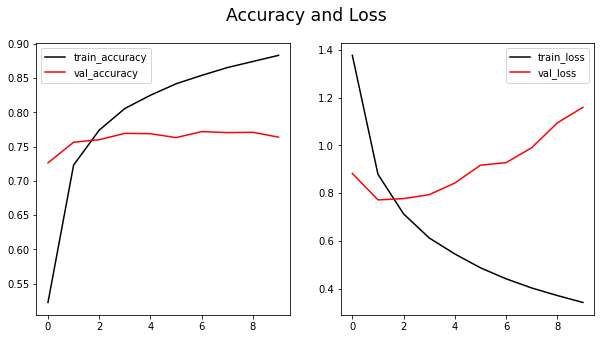

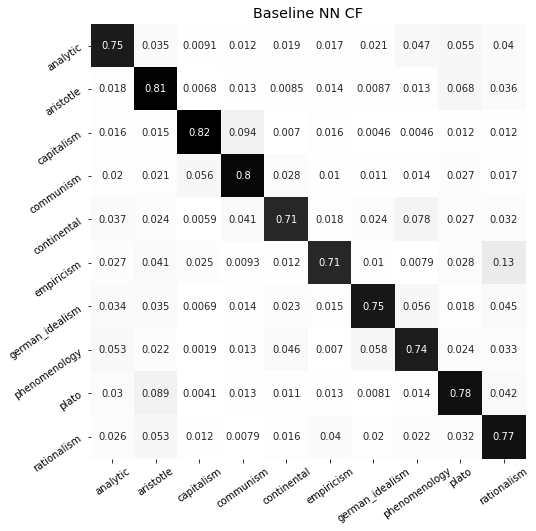




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     13233
           1       0.79      0.81      0.80     12760
           2       0.82      0.82      0.82      4598
           3       0.70      0.80      0.74      4499
           4       0.82      0.71      0.76      8422
           5       0.74      0.71      0.73      5068
           6       0.86      0.75      0.80     10685
           7       0.69      0.74      0.71      7251
           8       0.73      0.78      0.75      9602
           9       0.58      0.77      0.66      5694

    accuracy                           0.76     81812
   macro avg       0.76      0.76      0.76     81812
weighted avg       0.77      0.76      0.77     81812



In [18]:
summarize_model(history, test, preds, labels=flipped_dict, title='Baseline NN CF')

Seems good, though it did overfit towards the end. Next let's try a bidirectional LSTM.

### Bidirectional LSTM

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

weights= compute_class_weight('balanced', np.unique(y_train), y_train)
weights_dict = dict(zip( np.unique(y_train),weights))

In [21]:
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         10065536  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               71600     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
Total params: 10,139,921
Trainable params: 10,139,921
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
bidirectional_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=128, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

In the end, this model was worse than just throwing darts at a board with the 10 labels on it. It seems that bidirectional LSTM is not the way to go for us. 

In [ ]:
summarize_model()

### Multiple LSTM Layers 

Next, let's try training a model with multiple LSTM layers to see if that improves performance.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

weights= compute_class_weight('balanced', np.unique(y_train), y_train)
weights_dict = dict(zip( np.unique(y_train),weights))

In [26]:
# commented out layers indicate past attempts
# none were particularly successful
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))
    # model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(LSTM(50, return_sequences=False))


    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10077440  
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
dense_6 (Dense)              (None, None, 25)          1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 25)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                15200     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
T

None

In [27]:
mutli_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=128, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

Epoch 1/10
1534/1534 [==============================] - 169s 108ms/step - loss: 2.3018 - accuracy: 0.0905 - val_loss: 2.3059 - val_accuracy: 0.0548
Epoch 2/10
1534/1534 [==============================] - 164s 107ms/step - loss: 2.3014 - accuracy: 0.0834 - val_loss: 2.2980 - val_accuracy: 0.1021
Epoch 3/10
1534/1534 [==============================] - 165s 107ms/step - loss: 2.2721 - accuracy: 0.1147 - val_loss: 2.3417 - val_accuracy: 0.0699
Epoch 4/10
1534/1534 [==============================] - 165s 107ms/step - loss: 2.1404 - accuracy: 0.1776 - val_loss: 2.4236 - val_accuracy: 0.0824
Epoch 5/10
1534/1534 [==============================] - 165s 107ms/step - loss: 1.9530 - accuracy: 0.2496 - val_loss: 2.5542 - val_accuracy: 0.0879


This model also could not do any better than just random guessing. Since messing with LSTM layers didn't seem to produce any benefits for the model, let's work on some parameters in the original baseline model.

### Hyperparameter Tuning

### Custom Word Embeddings

### Using Glove Word Embeddings

In [100]:
print(classification_report(test, preds))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     13274
           1       0.82      0.78      0.80     12774
           2       0.83      0.80      0.81      4536
           3       0.69      0.79      0.73      4451
           4       0.80      0.74      0.77      8466
           5       0.71      0.77      0.74      5152
           6       0.83      0.77      0.80     10554
           7       0.70      0.75      0.72      7159
           8       0.71      0.80      0.75      9589
           9       0.68      0.71      0.70      5857

    accuracy                           0.77     81812
   macro avg       0.76      0.77      0.76     81812
weighted avg       0.77      0.77      0.77     81812



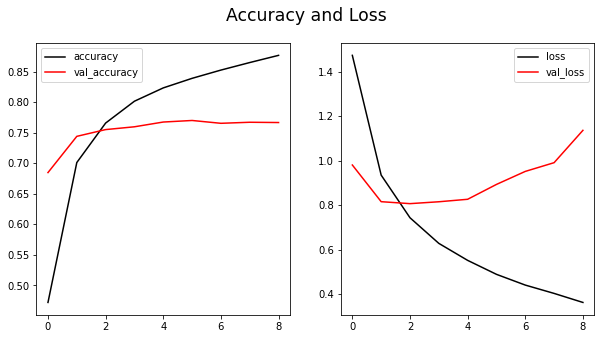

In [95]:
def show_curves_nn(model):
  history_df = pd.DataFrame(model.history)
  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
  fig.suptitle('Accuracy and Loss', fontsize='xx-large')
  ax1.plot(history_df['accuracy'], label='accuracy', color='black')
  ax1.plot(history_df['val_accuracy'], label='val_accuracy', color='red')
  legend = ax1.legend()
  ax2.plot(history_df['loss'], label='loss', color='black')
  ax2.plot(history_df['val_loss'], label='val_loss', color='red')
  legend = ax2.legend()

show_curves_nn(history)

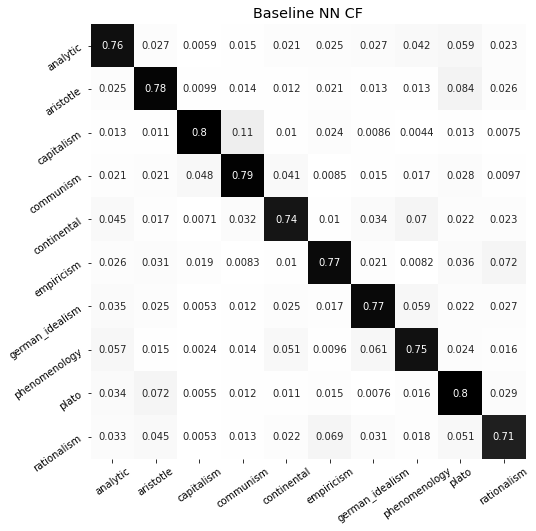

In [69]:
plot_pretty_nn_cf(test, preds, label_dict=flipped_dict, title='Baseline NN CF')

In [68]:
def plot_pretty_nn_cf(test_labels, predicted_labels, cmap='Greys', label_dict={}, title='CF'):
  fig, ax = plt.subplots(figsize=(8,8))
  cm = confusion_matrix(test_labels, predicted_labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm, cmap=cmap, annot=True, cbar=False, square=True)
  if label_dict != {}:
    ax.set_xticklabels([label_dict[int(x.get_text())] for x in ax.get_xticklabels()], rotation=35)
    ax.set_yticklabels([label_dict[int(x.get_text())] for x in ax.get_yticklabels()], rotation=35)
  ax.set_title(title, fontsize='x-large')
  plt.show()